In [1]:
import numpy as np
from helpers import *
from analytical_approaches import bernardes_eq, markov_approach, including_fusion

import networkx as nx

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ShortestPath.shortest_path import monte_carlo

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

from rich.progress import track

In [2]:
#Constants
vertices = 8
sim_count = 10000

So the grid would look like,

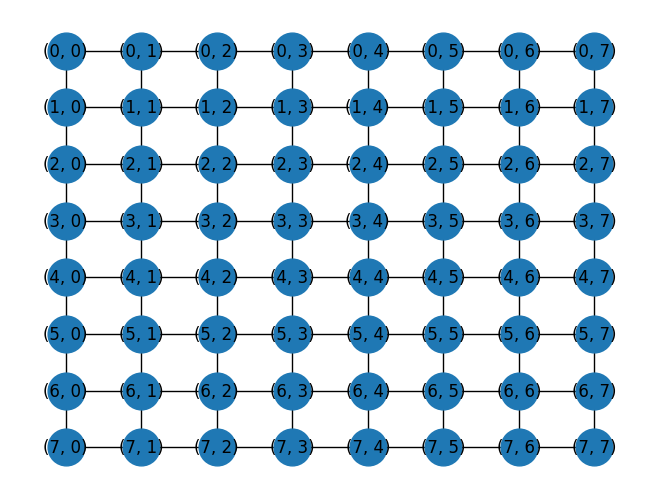

In [3]:
G = nx.grid_2d_graph(vertices, vertices)
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=700)

Before we present our novel results which include fusion, we recreate the published results for non-deterministic (p < 1) entanglement generation success and non-deterministic swap. The first has been published by Bernades et al and the second by Shchukin and Brand independently.

##### Non-deterministic p

In [4]:
p = 0.1; q = 1; k = 1
bernades = bernardes_eq(manhattan_distance(vertices), p)
mc = monte_carlo(vertices, sim_count, sim_count, p, 1, 1)

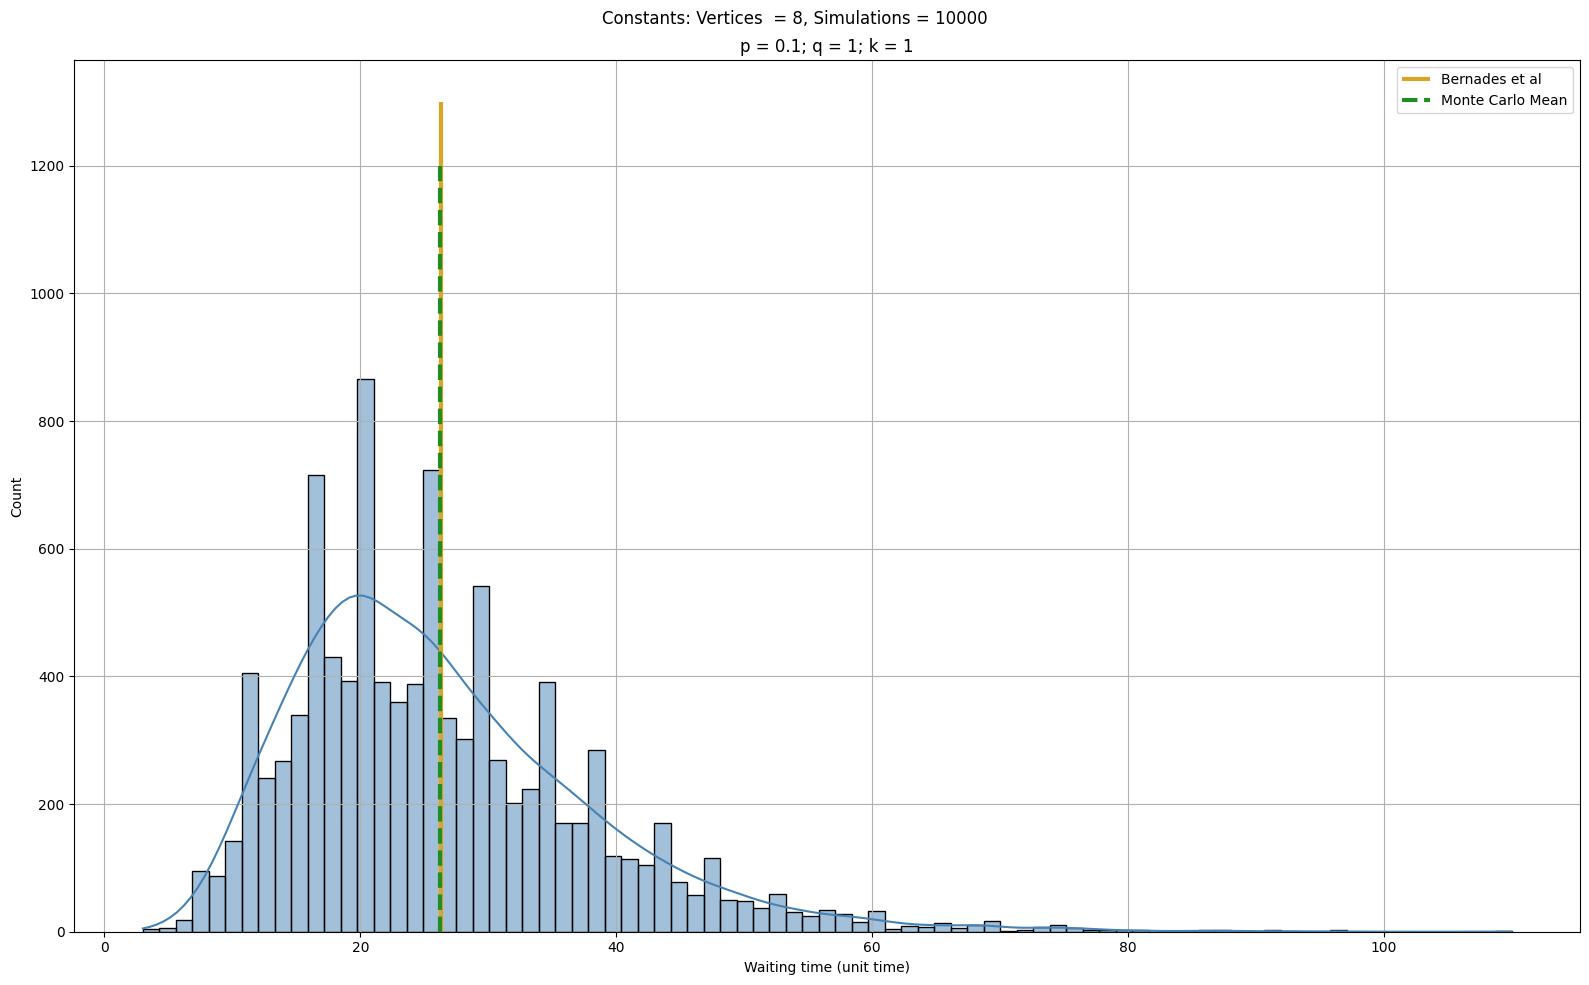

In [5]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(bernades, 0, 1300, colors='goldenrod', label = 'Bernades et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1200, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

We clearly see that the Monte-Carlo simulation provided by Brand works well with non-deterministic $p$.

##### Non-deterministic p & q

In [6]:
p = 0.1
q = 0.9
k = 1

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)

shchukin_vals = markov_approach(vertices, p, q)

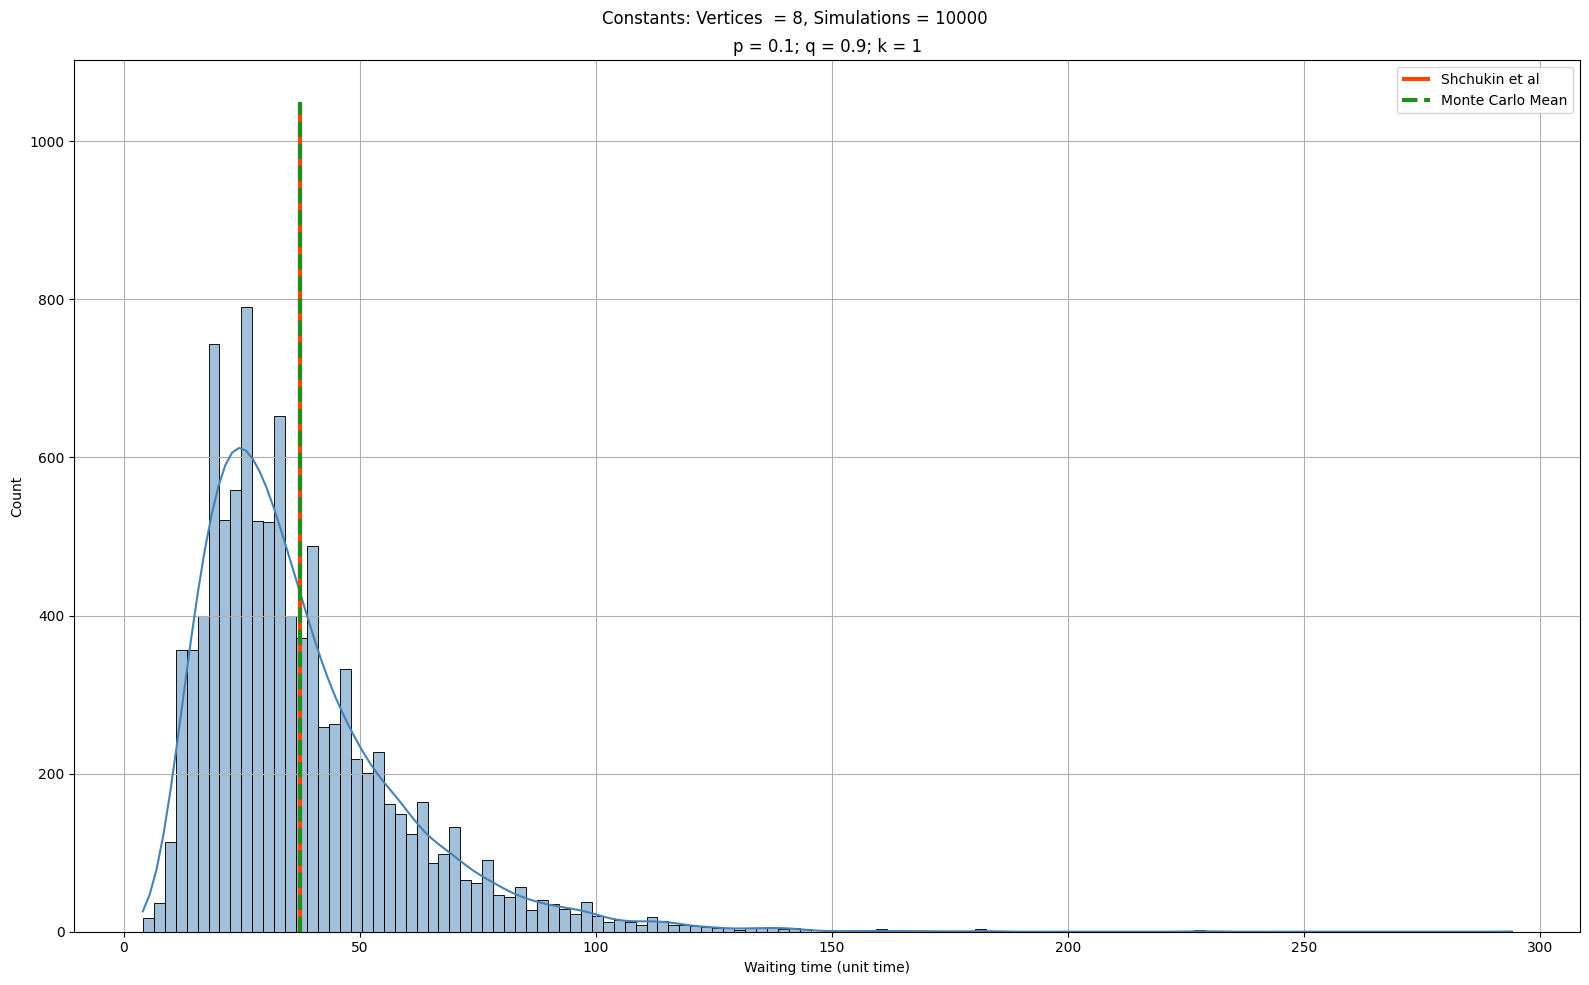

In [7]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(shchukin_vals, 0, 1050, colors ='orangered', label = 'Shchukin et al', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1050, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)

plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

Clearly, we see that the Shchukin model and the Brand model (which we will now call the Markov Chain and the Monte-Carlo simulation), align well for the stated values of the number of segments.

##### Including Fusion

We now present our novel solution introducing fusion to the Markov Chain and Monte-Carlo simulations. Further we will present some other methods of quantifying the latency, with the different of the new approach having an experimental base rather than theoretical.

In [8]:
p = 0.1
q = 0.9
k = 0.3

mc = monte_carlo(vertices, sim_count, sim_count, p, q, k)
fusion_vals = including_fusion(vertices, p, q, k)

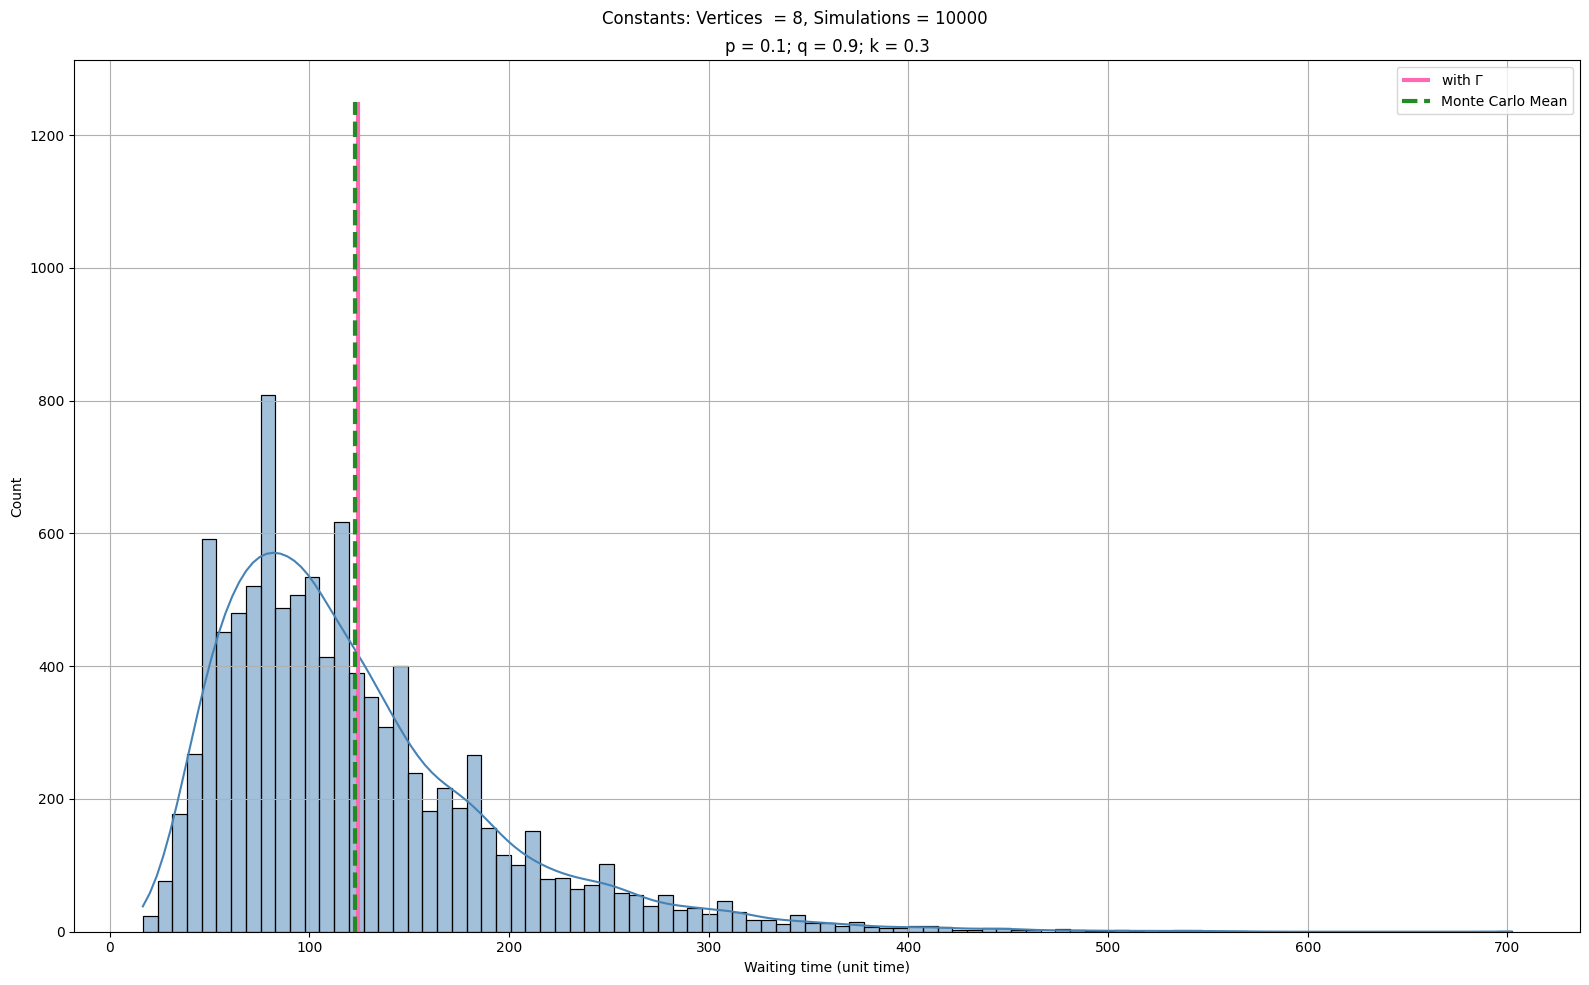

In [9]:
fig, ax = plt.subplots(figsize = (16, 10))

sns.histplot(mc, ax = ax, kde = True, color = 'steelblue')
ax.vlines(fusion_vals, 0, 1250, colors ='hotpink', label = r'with $\Gamma$', linewidth = 3)
ax.vlines(np.mean(mc), 0, 1250, colors='forestgreen', label = 'Monte Carlo Mean', linewidth = 3, linestyle = "dashed")
ax.set_xlabel("Waiting time (unit time)")
ax.set_ylabel("Count")
ax.set_title(f"p = {p}; q = {q}; k = {k}")
ax.legend(loc = 'best')
ax.grid(True)


plt.suptitle(f"Constants: Vertices  = {vertices}, Simulations = {sim_count}")

plt.tight_layout()

Once we have gained confidence that our model maps fusion properly, we can introduce the experimentally based method.

##### Evaluating the time taken in classical communication and quantum operations

First we need to address the probabilistic nature of entanglement. From a recent paper on Nature, they generated ~ 99 x 10^3 pairs of entangled photons per second. Giving us the expected waiting time for a single entangled qubit generation to be 0.00001010101 seconds, and if we assume that the loss of the fiber can translate to whether the receiving node receives a qubit or not, we can model the time taken to generate entanglement by multiplying expected number of attempts required and the time required to generate a laser pulse.

Similarily, from another recent Nature paper, the time taken to perform a SWAP gate and the gate error have been noted; gate error of 0.0205 and gate time of 2.13e-6 seconds. They implement a ZZ gate with phase rotation of pi/2.

In [10]:
#First we define all the deterministic variables

def p_l(L):
    return 10**((-0.2*L)/10)

q = 0.937708
k = 0.82452
c = 299792.458/1.4585 

def t_p(L):
    0.00001010101 + (L/c)

p_gen = 0.00001010101

t_q = 96.39e-6
t_k = 289.17e-6

classical_tp_color = "darkgray"
classical_tq_color = "gainsboro"
quantum_tp_color = "steelblue"
quantum_tq_color = "dodgerblue"
quantum_tk_color = "powderblue"
t_color = "forestgreen"

To quantify the time delay, we calculate the time taken to generate an elementary entanglement link between two nodes which can be given by:

$$
    T_p^r + nt_p + \frac{L_0}{c'} + T_p^a
$$

where $T_p^r$ is the time taken from the central node to request the entanglement link to be generated, $nt_p$ is the time taken in sending multiple photons to ensure an entangled link is generated, and $T_p^a$ is the time taken from the node to relay the end of the process to the central node.

For swapping,

$$
    T_q^r + t_q + T_q^a
$$

where $T_q^r$ is the time taken for a signal from the central node to the node for performing swapping, $t_q$ for the time taken to swap, and $T_q^a$ for the time taken for the node to relay the result back to the central node.

This entire process is repeated $n_q$ times as when swapping fails, the entanglement links need to be regenerated. Giving our pre-fusion latency as,

$$
    \tau = n_q((T_p^r + n_pt_p + T_p^a) +  (T_q^r + t_q + T_q^a))
$$

To include fusion, since it occurs independently of the other operations, it can be added onto $\tau$. However, failure in fusion results in a complete loss of entanglement and the system needs to restart. This gives our final equation for the latency as,

$$
    \tau = n_k(n_q((T_p^r + n_pt_p + T_p^a) +  (T_q^r + t_q + T_q^a)) + t_k)
$$

where $n_x$ is the number of times operation $x$ is attempted and $t_k$ is the time taken to perform fusion.

Breaking down this equation, we get,

Quantum: $n_kn_qn_pt_p + n_kn_q\frac{L_0}{c'} + n_kn_qt_q + n_kt_q$ 


Classical: $2n_kn_q\frac{L_0}{c'}(2v - 1)$

where $v$ is the number of vertices.

In [11]:
#Then we can simulate the timing distribution returning the number of attempts in entanglement, swapping and fusion.

def quantum_operations_count(distances):
    max_ratios = []; min_ratios = []; mean_ratios = []
    t_means = []; t_maxs = []; t_mins = []


    for L in track(distances):
        p = p_l(L)
        _, this_np, this_nq, this_nk = monte_carlo(vertices, sim_count, sim_count, p, q, k, ind = True, exp = True)

        this_np_max = max(this_np)
        this_np_mean = np.mean(this_np)
        this_np_min = min(this_np)
        this_nq_max = max(this_nq)
        this_nq_mean = np.mean(this_nq)
        this_nq_min = min(this_nq)
        this_nk_max = max(this_nk)
        this_nk_mean = np.mean(this_nk)
        this_nk_min = min(this_nk)

        t_classical_max = 2*this_nk_max*this_nq_max*(L/c)*(2*vertices-1)
        t_classical_min = 2*this_nk_min*this_nq_min*(L/c)*(2*vertices-1)
        t_classical_mean = 2*this_nk_mean*this_nq_mean*(L/c)*(2*vertices-1)

        t_quantum_max = this_nk_max*this_nq_max*this_np_max*p_gen + this_nk_max*this_nq_max*(L/c) + this_nk_max*this_nq_max*t_q+this_nk_max*t_k
        t_quantum_min = this_nk_min*this_nq_min*this_np_min*p_gen + this_nk_min*this_nq_min*(L/c) + this_nk_min*this_nq_min*t_q+this_nk_min*t_k
        t_quantum_mean = this_nk_mean*this_nq_mean*this_np_mean*p_gen + this_nk_mean*this_nq_mean*(L/c) + this_nk_mean*this_nq_mean*t_q+this_nk_mean*t_k

        t_means.append(t_quantum_mean+t_classical_mean)
        t_maxs.append(t_quantum_max+t_classical_max)
        t_mins.append(t_quantum_min+t_classical_min)

        max_ratio_1 = t_classical_max + t_quantum_max
        max_ratios.append((t_classical_max/max_ratio_1, t_quantum_max/max_ratio_1))

        min_ratio_1 = t_classical_min + t_quantum_min
        min_ratios.append((t_classical_min/min_ratio_1, t_quantum_min/min_ratio_1))

        mean_ratio_1 = t_classical_mean + t_quantum_mean
        mean_ratios.append((((this_nk_mean*this_nq_mean*(this_np_mean*p_gen + (L/c)))/ mean_ratio_1), #Time spent in generating entanglement
                           ((this_nk_mean*this_nq_mean*t_q)/ mean_ratio_1), #Time spent in performing swap
                           ((this_nk_mean*t_k)/ mean_ratio_1), #Time spent in performing fusion
                           ((this_nk_mean*this_nq_mean*(2*vertices)*(L/c)/ mean_ratio_1)), #Time spent in requesting and acknowledging entanglement
                           ((this_nk_mean*this_nq_mean*(2*(vertices - 1))*(L/c)/ mean_ratio_1)) #Time spent in requesting and acknowledging swap
                           ))

    y_error = list(map(lambda x: (max_ratios[x][0] - min_ratios[x][0])/2, range(len(min_ratios))))

    return mean_ratios, y_error, t_maxs, t_mins, t_means


#Generate the data
distances = range(1, 100, 10)
mean_ratios, y_error, t_maxs, t_mins, t_means = quantum_operations_count(distances)


Output()

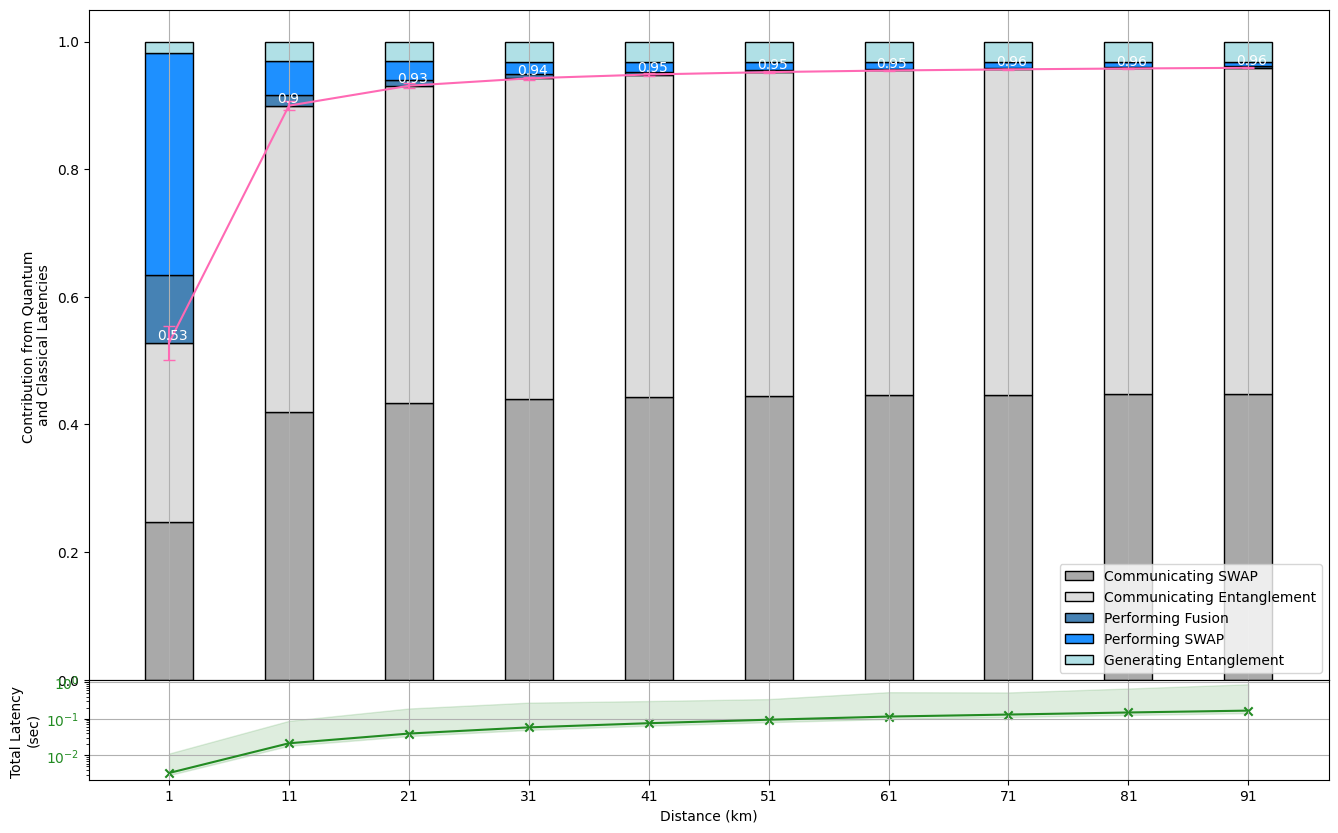

In [12]:
res = map(np.array, mean_ratios)
res = np.array(list(res))
res = np.flip(res, axis=1)

num_rows = len(res)

fig, ax = plt.subplots(figsize = (16, 10))

ind = distances

res = res.T

colors = ["darkgray", "gainsboro", "steelblue", "dodgerblue", "powderblue"]
labels = ["Generating Entanglement", "Performing SWAP", "Performing Fusion", "Communicating Entanglement", "Communicating SWAP"]
labels.reverse()

bottom = np.zeros(num_rows)  
for i in range(res.shape[0]):
    ax.bar(ind, res[i], bottom=bottom, width = 4, color=colors[i], label=labels[i], edgecolor = 'black')
    bottom += res[i]

for j, r in enumerate(res.T):
    ax.text(distances[j]-1, r[0]+r[1]+0.005, f"{np.round(r[0]+r[1], 2)}", color = 'white')

plt.errorbar(distances, res[0, :] + res[1, :], yerr = y_error, capsize = 4, color = 'hotpink')

ax.xaxis.set_tick_params(labelbottom = False)

divider = make_axes_locatable(ax)

ax1 = divider.append_axes("bottom", 1., pad = 0, sharex = ax)
ax1.xaxis.set_tick_params() 
ax1.grid(True) 

ax1.fill_between(distances, t_maxs, t_mins, alpha = 0.15, color = t_color)
ax1.scatter(distances, t_means, marker = 'x', color = t_color)
ax1.plot(distances, t_means, color = t_color)
ax1.tick_params(axis='y', labelcolor=t_color, which = 'both')
ax1.set_yscale('log')

ax1.set_xlabel('Distance (km)')
ax.set_ylabel('Contribution from Quantum \nand Classical Latencies', multialignment = 'center')
ax1.set_ylabel('Total Latency \n(sec)')
ax.legend(loc = 'lower right')
ax.set_xticks(np.arange(0, max(distances), 10)+1, distances)
ax.xaxis.grid(True)
